In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
state=1

In [3]:
pairedcp=sns.color_palette('Paired')[0:2]

In [4]:
# with open('test_ind.pickle', 'rb') as handle:
#     test_ind = pickle.load(handle)

# with open('train_ind.pickle', 'rb') as handle:
#     train_ind = pickle.load(handle)
    
with open('big_test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('big_train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)

datanums = len(test_ind)+len(train_ind)

In [5]:
def gen_lc(state,trainsize,testsize):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]    
    
    dropfeat = [a for a in dropfeat if a not in ['D$_{qs}$', 'F$_{qs}$', 'FA$_{qs}$', 'FI$_{qs}$']]
    # with open('test_ind.pickle', 'rb') as handle:
    #     test_ind = pickle.load(handle)
    
    # with open('train_ind.pickle', 'rb') as handle:
    #     train_ind = pickle.load(handle)
        
    with open('big_test_ind.pickle', 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open('big_train_ind.pickle', 'rb') as handle:
        train_ind = pickle.load(handle)
  
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, train_size=trainsize, test_size=testsize,random_state=42)
    print(len(train_ind),len(test_ind))    
    
    train = []
    test = []
        
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    # TZP: 1e-5
    # DZP: 1e-5
    # mb: 1e-3
    for i in sorted(glob('ANO-RCC-VTZP/')):
        for j in glob(os.path.join(i,'ozone_*')):
            for k in train_ind:
                if f"{k:.2f}" in j:
                    traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+f'_{state}.csv'),index_col=0)
                    # traindf = traindf[traindf['Pair_Energies'].abs()>=1e-5]
                    train.append(traindf)
                    recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                    traincnt+=1
                    
            for l in test_ind:
                if f"{l:.2f}" in j:
                    testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+f'_{state}.csv'),index_col=0)
                    # testdf = testdf[testdf['Pair_Energies'].abs()>=1e-5]
                    test.append(testdf)                    
                    recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                    testcnt+=1
                    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
    'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
    'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
    'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
    'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
    'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
    'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
    'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
    'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
    'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
    'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
    'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
    'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
    'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
    'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
    'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
    'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
    'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
    'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
    'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
    'typ_0':'$type_0$',
    'typ_1':'$type_1$',
    'typ_2':'$type_2$',
    'typ_3':'$type_3$'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    kwargs = dict(pd.read_excel(f"ozone_VTZP_MS_{state}_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0).loc[f'root_{state}']
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E']
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E']
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0).loc[f'root_{state}']
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E']
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E']
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [18]:
def plot(state,data,trainsize,save=False):
    pair_r2 = []
    pair_mae = []
    corr_r2 = []
    corr_mae = []
    for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
        traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
        traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']
    
        testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
        testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
        
        pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
        pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))
    
        corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
        corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))
    
    dfpair_r2 = pd.DataFrame(pair_r2,columns=['Train Size', "Train", "Test"])
    dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Train Size', "Train", "Test"])
    dfpair_mae = pd.DataFrame(pair_mae,columns=['Train Size', "Train", "Test"])
    dfcorr_mae = pd.DataFrame(corr_mae,columns=['Train Size', "Train", "Test"])

    print(dfcorr_r2.sort_values(by=['Train Size']))
    
    # fig, ax = plt.subplots(2,2,sharex=True)
    # sns.lineplot(dfpair_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][0],palette=pairedcp)
    # sns.lineplot(dfcorr_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp)
    # ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
    # ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')    
    # ax[0][0].set_xlim(0,304)
    # ax[0][1].set_xlim(0,304)
    # ax[0][0].set_ylim(-.74,1.1)
    # ax[0][1].set_ylim(-.74,1.1)
    # ax[0][0].set_ylabel("R$^{2}$")
    # ax[0][1].set_ylabel("R$^{2}$")
    # sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][0],palette=pairedcp)
    # ax[1][0].set_ylim(0,1)
    # sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][1],palette=pairedcp)
    # ax[1][1].set_ylim(0,8)
    # ax[1][0].set_ylabel("MAE (mE$_{h}$)")
    # ax[1][1].set_ylabel("MAE (mE$_{h}$)")
    # # plt.suptitle(f"{trainsize},{testsize}")
    # plt.tight_layout()
    # if save:
    #     plt.savefig(f'images/{state}_learning_curves.png',dpi=300,bbox_inches='tight')    

    # fig, ax = plt.subplots(2,1,sharex=True)
    # sns.lineplot(dfpair_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][0],palette=pairedcp)
    # sns.lineplot(dfcorr_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp)
    # ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
    # ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')    
    # ax[0][0].set_xlim(0,304)
    # ax[0][1].set_xlim(0,304)
    # ax[0][0].set_ylim(-.74,1.1)
    # ax[0][1].set_ylim(-.74,1.1)
    # ax[0][0].set_ylabel("R$^{2}$")
    # ax[0][1].set_ylabel("R$^{2}$")
    fig, ax = plt.subplots(1,2,sharex=True,figsize=(8,4))
    sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0],palette=pairedcp)
    ax[0].set_ylim(0,0.6)
    sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1],palette=pairedcp)
    ax[1].set_ylim(0,15)
    ax[0].set_ylabel("MAE (mE$_{h}$)")
    ax[1].set_ylabel("MAE (mE$_{h}$)")
    # plt.suptitle(f"{trainsize},{testsize}")
    plt.tight_layout()
    if save:
        plt.savefig(f'images/{state}_learning_curves.png',dpi=300,bbox_inches='tight')    

In [7]:
datanums

304

In [8]:


# for j in ranges:
#     data = []
#     for i in ranges:
#         if j+i<=1:
#             # print(i,j)
#             data.append((int(i * datanums),gen_lc(i,j)))
#     plot(data,j)
#     plt.show()
    


In [20]:
data = []
ranges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
# ranges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for i in ranges:
    data.append((int(i * datanums),gen_lc(state,i,0.1)))


30 31
R2: 0.9970,0.9244
RMSE (mEh): 0.2519,1.2642
60 31
R2: 0.9982,0.9729
RMSE (mEh): 0.1964,0.7575
91 31
R2: 0.9979,0.9909
RMSE (mEh): 0.2110,0.4380
121 31
R2: 0.9983,0.9882
RMSE (mEh): 0.1888,0.5000
152 31
R2: 0.9984,0.9944
RMSE (mEh): 0.1851,0.3430
182 31
R2: 0.9987,0.9953
RMSE (mEh): 0.1659,0.3137
212 31
R2: 0.9986,0.9952
RMSE (mEh): 0.1711,0.3178
243 31
R2: 0.9988,0.9966
RMSE (mEh): 0.1604,0.2690
273 31
R2: 0.9988,0.9969
RMSE (mEh): 0.1593,0.2559


   Train Size     Train       Test
0          30  0.840188 -10.354584
1          60  0.895295  -0.059867
2          91  0.852546   0.341192
3         121  0.919392   0.365898
4         152  0.904176   0.467848
5         182  0.935353   0.746232
6         212  0.915068   0.718103
7         243  0.915742   0.787862
8         273  0.907753   0.827399


/tmp/ipykernel_232127/3392256015.py:60: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0],palette=pairedcp)
/tmp/ipykernel_232127/3392256015.py:62: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1],palette=pairedcp)


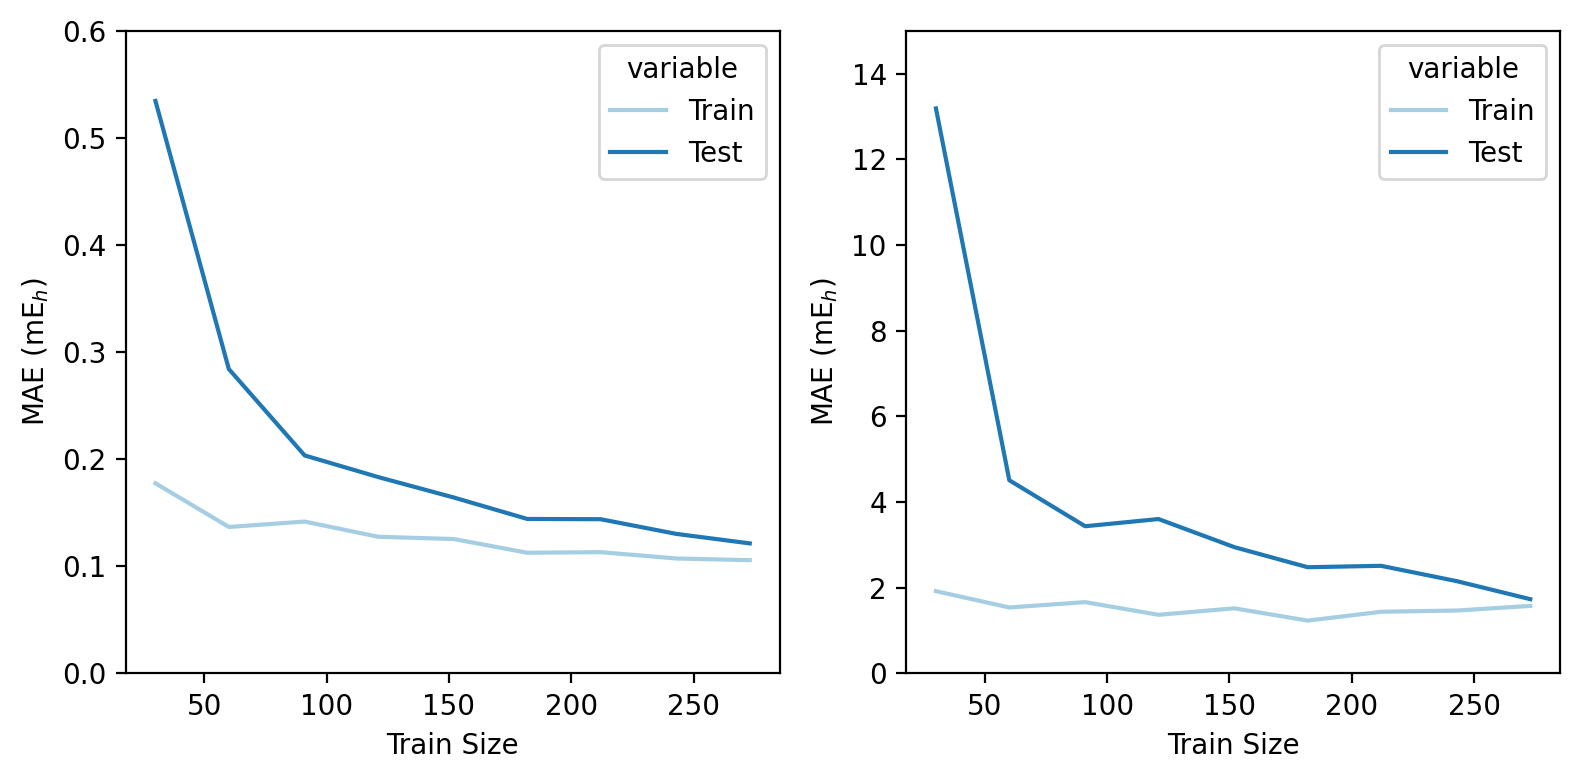

In [21]:
plot(state,data,0.1,True)
plt.show()

In [11]:
def gen_cut(state,cutoff):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]

    dropfeat = [a for a in dropfeat if a not in ['D$_{qs}$', 'F$_{qs}$', 'FA$_{qs}$', 'FI$_{qs}$']]
    # with open('test_ind.pickle', 'rb') as handle:
    #     test_ind = pickle.load(handle)
    
    # with open('train_ind.pickle', 'rb') as handle:
    #     train_ind = pickle.load(handle)
        
    with open('big_test_ind.pickle', 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open('big_train_ind.pickle', 'rb') as handle:
        train_ind = pickle.load(handle)
  
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, test_size=0.3,random_state=42)
    print(len(train_ind),len(test_ind))    
    
    train = []
    test = []
        
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    for i in sorted(glob('ANO-RCC-VTZP/')):
        for j in glob(os.path.join(i,'ozone_*')):
            for k in train_ind:
                if f"{k:.2f}" in j:
                    traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+f'_{state}.csv'),index_col=0)
                    # traindf = traindf[traindf['Pair_Energies'].abs()>=1e-5]
                    train.append(traindf)
                    recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                    traincnt+=1
                    
            for l in test_ind:
                if f"{l:.2f}" in j:
                    testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+f'_{state}.csv'),index_col=0)
                    # testdf = testdf[testdf['Pair_Energies'].abs()>=1e-5]
                    test.append(testdf)                    
                    recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                    testcnt+=1
                    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
    'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
    'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
    'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
    'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
    'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
    'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
    'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
    'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
    'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
    'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
    'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
    'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
    'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
    'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
    'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
    'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
    'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
    'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
    'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
    'typ_0':'type_0',
    'typ_1':'type_1',
    'typ_2':'type_2',
    'typ_3':'type_3'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    kwargs = dict(pd.read_excel(f"ozone_VTZP_MS_{state}_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0).loc[f'root_{state}']
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E']
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E']
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0).loc[f'root_{state}']
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E']
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E']
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [12]:
14-3

11

In [13]:
data = []
for i in np.logspace(-14,-3,12):
    print(i)
    data.append((i,gen_cut(state,i)))


pair_r2 = []
pair_mae = []
corr_r2 = []
corr_mae = []
for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
    traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
    traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']

    testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
    testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
    pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))

    corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
    corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))

dfpair_r2 = pd.DataFrame(pair_r2,columns=['Cutoff', "Train", "Test"])
dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Cutoff', "Train", "Test"])
dfpair_mae = pd.DataFrame(pair_mae,columns=['Cutoff', "Train", "Test"])
dfcorr_mae = pd.DataFrame(corr_mae,columns=['Cutoff', "Train", "Test"])




1e-14
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-13
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-12
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-11
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-10
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-09
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-08
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-07
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
1e-06
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
9.999999999999999e-06
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
0.0001
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475
0.001
212 92
R2: 0.9986,0.9943
RMSE (mEh): 0.1729,0.3475


In [14]:
dfpair_r2

,Cutoff,Train,Test
0,1.000000e-14,0.99859,0.994293
1,1.000000e-13,0.99859,0.994293
2,1.000000e-12,0.99859,0.994293
3,1.000000e-11,0.99859,0.994293
4,1.000000e-10,0.99859,0.994293
5,1.000000e-09,0.99859,0.994293
6,1.000000e-08,0.99859,0.994293
7,1.000000e-07,0.99859,0.994293
8,1.000000e-06,0.99859,0.994293
9,1.000000e-05,0.99859,0.994293


/tmp/ipykernel_232127/624012278.py:36: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0],palette=pairedcp)
/tmp/ipykernel_232127/624012278.py:38: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1],palette=pairedcp)


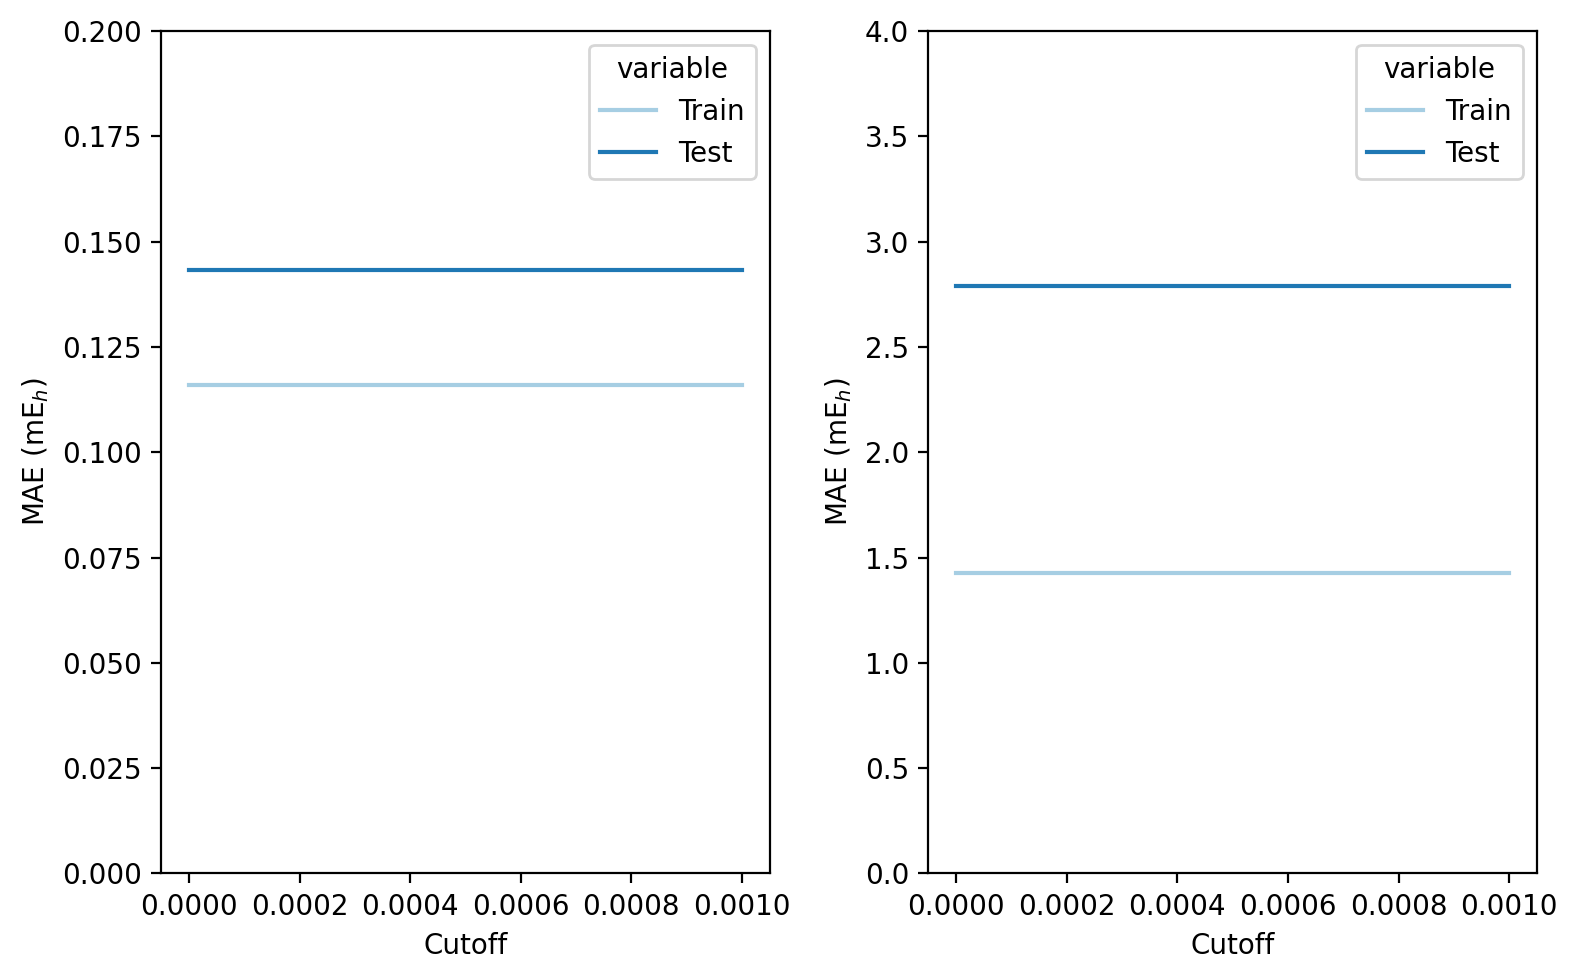

In [15]:
# fig, ax = plt.subplots(2,2,sharex=True)
# sns.lineplot(dfpair_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][0],palette=pairedcp)
# sns.lineplot(dfcorr_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp)
# # ax[0][0].set_xlim(0,500)
# # ax[0][1].set_xlim(0,500)
# ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
# ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')
# ax[0][0].set_xscale("log")
# ax[0][1].set_xscale("log")
# ax[0][0].set_ylim(-.74,1.1)
# ax[0][1].set_ylim(-.74,1.1)
# ax[0][0].set_xlim(10**-15,0)
# # ax[0][1].set_xlim(-.74,1.1)
# ax[0][0].set_ylabel("R$^{2}$")
# ax[0][1].set_ylabel("R$^{2}$")
# sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][0],palette=pairedcp)
# ax[1][0].set_ylim(0,0.25)
# sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][1],palette=pairedcp)
# ax[1][1].set_ylim(0,8)
# ax[1][0].set_ylabel("MAE (mE$_{h}$)")
# ax[1][1].set_ylabel("MAE (mE$_{h}$)")
# plt.tight_layout()
# plt.savefig(f'images/{state}_cutoff_curves.png',dpi=300,bbox_inches='tight')


pairedcp=sns.color_palette('Paired')
fig, ax = plt.subplots(1,2,sharex=True,figsize=(8,5))
# sns.lineplot(r2_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0][0],palette=pairedcp[4:6])
# sns.lineplot(r2_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp[4:6])
# ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
# ax[0][1].set_title(r'Correlation Energies (E$_{2}$)')
# ax[0][0].set_ylim(0.9,1.01)
# ax[0][1].set_ylim(0.9,1.01)
# ax[0][0].set_ylabel("R$^{2}$")
# ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0],palette=pairedcp)
ax[0].set_ylim(0,0.2)
sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1],palette=pairedcp)
ax[1].set_ylim(0,4)
ax[0].set_ylabel("MAE (mE$_{h}$)")
ax[1].set_ylabel("MAE (mE$_{h}$)")
plt.tight_layout()
plt.savefig(f'images/{state}_cutoff_curves.png',dpi=300,bbox_inches='tight')

In [16]:
dfcorr_r2.sort_values(by=['Train','Test'])

,Cutoff,Train,Test
0,1.000000e-14,0.92768,0.386984
1,1.000000e-13,0.92768,0.386984
2,1.000000e-12,0.92768,0.386984
3,1.000000e-11,0.92768,0.386984
4,1.000000e-10,0.92768,0.386984
5,1.000000e-09,0.92768,0.386984
6,1.000000e-08,0.92768,0.386984
7,1.000000e-07,0.92768,0.386984
8,1.000000e-06,0.92768,0.386984
9,1.000000e-05,0.92768,0.386984


In [17]:
(dfcorr_r2['Train']-dfcorr_r2['Test']).abs()
# .argmin()

0     0.540696
1     0.540696
2     0.540696
3     0.540696
4     0.540696
5     0.540696
6     0.540696
7     0.540696
8     0.540696
9     0.540696
10    0.540696
11    0.540696
dtype: float64